# GnomAD_df class use example
After each cell There is an explanation of what it is doing

In [2]:
#The first two imports are only for loading the class from it's location.
#they are not necessery
import sys
import os
sys.path.append(os.path.abspath("code"))
# these are  needed-
import pandas as pd
from GnomAD_df_class import GnomAD_df


In [2]:
gdf = GnomAD_df(path='data/main.prq',
                peak_file='data/hATAC_mATAC_peak.bed.gz',
                remove_unkown=True,
                remove_phased_gt=True,
                only_peak_variants=True)
gdf.get_table().head()

applying filters
removing variants outside of peak interval
removed unkwon genotypes (e.g "./.")
replaced phased genotype (e.g "0|1" -> "0/1")
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]

### Explanation:
The class constructor have only one mandatory variable, the path to the parquet file. <br>
the rest of the argument, except the peak_file (it can be left empty), are the deafult argument. <br>
Variable description:<br>
- peak_file - bed file which contains the following columns - CHROM,FROM,TO,INTERVAL_ID,  (w/o header)
- remove_unknown - add a filter which removes unkwon genotypes (e.g "./.")' 
- remove_phased_gt -  add a filter which replace phased genotype (e.g "0|1" -> "0/1")
- only_peak_variants -  add a filter which removes variants outside of peak interval 
<br>

Whenever get_table or any other function that requeires to apply the filters, only then the class creates a sub dataframe which the filters apllied on it. <br>
During the filteration process, the filter's descriptions will be printed, unless verbos=False. <br>

In [3]:
gdf.reset_table(remove_phased_gt=False,
    remove_unkown=False,
    only_peak_variants=False)
gdf.get_table().head()


applying filters
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP AS22WG010:GT  \
CHROM POS   ALT REF                                                       
chr1  10117 A   C           NaN          NaN           NaN          NaN   
      10141 A   C           NaN          NaN           NaN          NaN   
      10146 A   AC          NaN          NaN           NaN          NaN   
      10151 A   T           NaN          NaN           NaN          NaN   
      10153 T   A           NaN          NaN           NaN          NaN   

                     AS22WG010:DP AS22WG011:GT  AS22WG011:DP AS22WG023:GT  \
CHROM POS   ALT REF                                                         
chr1  10117 A   C             NaN          NaN           NaN          NaN   
      10141 A   C             NaN          NaN           NaN          NaN   
      10146 A   AC            NaN          NaN           NaN          NaN   
      10151 A   T             NaN          NaN           NaN          NaN   
      10153 T   A             NaN          NaN           NaN          NaN   

                     AS22WG023:DP AS22WG024:GT  ...  PKGen166:GT PKGen166:DP  \
CHROM POS   ALT REF                             ...                            
chr1  10117 A   C             NaN          NaN  ...          NaN         NaN   
      10141 A   C             NaN          NaN  ...          NaN         NaN   
      10146 A   AC            NaN          1/1  ...          NaN         NaN   
      10151 A   T             NaN          NaN  ...          NaN         NaN   
      10153 T   A             NaN          NaN  ...          NaN         NaN   

                     PKGen177:GT PKGen177:DP  PKGen186:GT PKGen186:DP  \
CHROM POS   ALT REF                                                     
chr1  10117 A   C            NaN         NaN          NaN         NaN   
      10141 A   C            NaN         NaN          NaN         NaN   
      10146 A   AC           NaN         NaN          NaN         NaN   
      10151 A   T            NaN         NaN          NaN         NaN   
      10153 T   A            NaN         NaN          NaN         NaN   

                     PKGen172:GT PKGen172:DP  PKGen187:GT PKGen187:DP  
CHROM POS   ALT REF                                                    
chr1  10117 A   C            NaN         NaN          NaN         NaN  
      10141 A   C            NaN         NaN          NaN         NaN  
      10146 A   AC           NaN         NaN          NaN         NaN  
      10151 A   T            NaN         NaN          NaN         NaN  
      10153 T   A            NaN         NaN          NaN         NaN  

[5 rows x 76 columns]

### Explanation:
In the cell below, No filter was applied. The original table is shown. <br>
Now lets filter it up!

In [4]:
gdf.remove_non_peak_variants()
gdf.remove_phasing()
gdf.remove_unkown()
gdf.get_table().head()

applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]

### Explanation:
Magic! We got the same table from 2 cells ago! <br>
Notice that the order of filteration changed. This is important, if we would like to remove a filter, we can do it by it's index. <br>
Of course there is a simple way to know the filters index... <br>

Lets see:

In [5]:
gdf.reset_table(remove_phased_gt=True,
    remove_unkown=True,
    only_peak_variants=True)
display(gdf.get_table().head())
gdf.filter_DP(31)
print('\n')
print("look on AS22WG009:GT, 4th & 5th row, \n it's written NaN since we filtered according to dp thrshold of 31 and above ")
print('\n')
display(gdf.get_table().head())


applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]



look on AS22WG009:GT, 4th & 5th row, 
 it's written NaN since we filtered according to dp thrshold of 31 and above 


applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
Removing variants with reading depth 31 or below
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          NaN          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          NaN          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            NaN          20.0          NaN          21.0   
      826893 A   G            NaN          25.0          NaN          22.0   
      827209 C   G            0/1          35.0          NaN          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            NaN          27.0          NaN  ...   
      826893 A   G            NaN          17.0          NaN  ...   
      827209 C   G            NaN          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            NaN        26.0          NaN        27.0   
      826893 A   G            NaN        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            NaN        24.0          NaN        23.0   
      826893 A   G            1/1        36.0          NaN        26.0   
      827209 C   G            NaN        31.0          NaN        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            NaN        28.0  

[5 rows x 76 columns]

Since our real threshold is 10, we need to fix it. <br>
1st we need to find the index of the filter

In [6]:
print("current filters:")
gdf.print_filters()
print("\n lets remove filter no 3")
gdf.remove_filter(3)
print('\n current filters: ')
gdf.get_table().head()

current filters:
0. removing variants outside of peak interval
1. replaced phased genotype (e.g "0|1" -> "0/1")
2. removed unkwon genotypes (e.g "./.")
3. Removing variants with reading depth 31 or below

 lets remove filter no 3

 current filters: 
applying filters
removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
getting table


INTERVAL_ID AS22WG009:GT  AS22WG009:DP  \
CHROM POS    ALT REF                                                   
chr1  634112 C   T         PGRA.SER.GRA_1          0/1          86.0   
      778639 G   A    PGRA.SER.GRA.PSER_2          NaN           NaN   
      779047 A   G    PGRA.SER.GRA.PSER_2          1/1          34.0   
      826893 A   G    PGRA.SER.GRA.PSER_3          1/1          30.0   
      827209 C   G    PGRA.SER.GRA.PSER_3          1/1          25.0   

                     AS22WG010:GT  AS22WG010:DP AS22WG011:GT  AS22WG011:DP  \
CHROM POS    ALT REF                                                         
chr1  634112 C   T            0/1          46.0          0/1          46.0   
      778639 G   A            NaN           NaN          NaN           NaN   
      779047 A   G            1/1          20.0          1/1          21.0   
      826893 A   G            0/1          25.0          1/1          22.0   
      827209 C   G            0/1          35.0          1/1          18.0   

                     AS22WG023:GT  AS22WG023:DP AS22WG024:GT  ...  \
CHROM POS    ALT REF                                          ...   
chr1  634112 C   T            0/1          49.0          0/1  ...   
      778639 G   A            NaN           NaN          NaN  ...   
      779047 A   G            1/1          27.0          1/1  ...   
      826893 A   G            1/1          17.0          1/1  ...   
      827209 C   G            1/1          26.0          1/1  ...   

                      PKGen166:GT PKGen166:DP  PKGen177:GT PKGen177:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       204.0          1/1       735.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        26.0          1/1        27.0   
      826893 A   G            1/1        30.0          1/1        36.0   
      827209 C   G            1/1        43.0          1/1        43.0   

                      PKGen186:GT PKGen186:DP  PKGen172:GT PKGen172:DP  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T            0/1       138.0          1/1       290.0   
      778639 G   A            NaN         NaN          NaN         NaN   
      779047 A   G            1/1        24.0          1/1        23.0   
      826893 A   G            1/1        36.0          1/1        26.0   
      827209 C   G            0/1        31.0          0/1        29.0   

                      PKGen187:GT PKGen187:DP  
CHROM POS    ALT REF                           
chr1  634112 C   T            NaN         NaN  
      778639 G   A            NaN         NaN  
      779047 A   G            1/1        46.0  
      826893 A   G            1/1        36.0  
      827209 C   G            1/1        28.0  

[5 rows x 76 columns]

Yay :) the table looks similar to the original! <br>
<br>
## Example : Filtering the table according to thresholds

After the short torturial above, see how easily is to achive a table which contains variants acoording to given thresholds.<br>
Let's say we want only variants with reading depth (DP) > 10 & gnomAD allele frequency < 0.01 <br>
First, lts see how many variant each sample have before applying the filters:    

In [7]:
gdf.reset_table() # make sure we cleaned all the mess from the cell above

print('first step: getting a boolean table, which suggest if a sample have a variant or not\n')
bool_df = gdf.bool_variant_df()
display(bool_df.head())
print('\nNow lets count how many variants the first 5 sample have -')
all_v = bool_df.drop(columns=['AF','INTERVAL_ID']).sum().head()
display(all_v)


first step: getting a boolean table, which suggest if a sample have a variant or not

removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")


AF          INTERVAL_ID  AS22WG009  AS22WG010  \
CHROM POS    ALT REF                                                        
chr1  634112 C   T    0.581946       PGRA.SER.GRA_1       True       True   
      778639 G   A    0.127933  PGRA.SER.GRA.PSER_2      False      False   
      779047 A   G    0.819806  PGRA.SER.GRA.PSER_2       True       True   
      826893 A   G    0.730133  PGRA.SER.GRA.PSER_3       True       True   
      827209 C   G    0.739536  PGRA.SER.GRA.PSER_3       True       True   

                      AS22WG011  AS22WG023  AS22WG024  AS22WG004  AS22WG005  \
CHROM POS    ALT REF                                                          
chr1  634112 C   T         True       True       True       True       True   
      778639 G   A        False      False      False      False      False   
      779047 A   G         True       True       True       True       True   
      826893 A   G         True       True       True       True       True   
      827209 C   G         True       True       True       True       True   

                      AS22WG006  ...  PKGen169  PKGen176  PKGen171  PKGen185  \
CHROM POS    ALT REF             ...                                           
chr1  634112 C   T         True  ...      True      True      True      True   
      778639 G   A        False  ...     False     False     False      True   
      779047 A   G         True  ...      True      True      True      True   
      826893 A   G         True  ...      True      True      True     False   
      827209 C   G         True  ...      True      True      True     False   

                      PKGen182  PKGen166  PKGen177  PKGen186  PKGen172  \
CHROM POS    ALT REF                                                     
chr1  634112 C   T        True      True      True      True      True   
      778639 G   A       False     False     False     False     False   
      779047 A   G        True      True      True      True      True   
      826893 A   G        True      True      True      True      True   
      827209 C   G        True      True      True      True      True   

                      PKGen187  
CHROM POS    ALT REF            
chr1  634112 C   T       False  
      778639 G   A       False  
      779047 A   G        True  
      826893 A   G        True  
      827209 C   G        True  

[5 rows x 39 columns]


Now lets count how many variants the first 5 sample have -


AS22WG009    39517
AS22WG010    39512
AS22WG011    39495
AS22WG023    36770
AS22WG024    36837
dtype: int64

Lets apply the filters:

In [8]:
DP_t = 10 
AF_t = 0.01
gdf.filter_DP(DP_t)
gdf.filter_AF(AF_t, remove_unkwon=True)
bool_df = gdf.bool_variant_df()
print('\nNow lets count how many variants the first 5 sample have -')
filter_v = bool_df.drop(columns=['AF','INTERVAL_ID']).sum().head()
display(pd.concat([all_v.rename('total_variants'),filter_v.rename("DP > 10 & AF < 0.01")], axis=1))


Notice the  remove_unkwon variable in 'filter_AF' function. If set to 'True' (default is 'False'), variants without reported allele frequency in gnomAD will be removed. <br>

Since I love one liner, pipping is also possible :) <br>
Let's do the same with less lines of code! <br>
(Note: The following is just POC, this is a bad example of code writing)

In [9]:
gdf.reset_table()
filter_v = gdf.filter_DP(DP_t).filter_AF(AF_t,  remove_unkwon=True).bool_variant_df().drop(columns=['AF','INTERVAL_ID']).sum().head()
display(pd.concat([all_v.rename('total_variants'),filter_v.rename("DP > 10 & AF < 0.01")], axis=1))

removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
Removing variants with reading depth 10 or below
Removing variants with allele frequency above 0.01 and variants with no record on gnomAD


,total_variants,DP > 10 & AF < 0.01
AS22WG009,39517,179
AS22WG010,39512,183
AS22WG011,39495,176
AS22WG023,36770,30
AS22WG024,36837,42


Since the function of getting the amount of variant in each sample is something we want to do often, there is a function that does that. <br>
so to summrise it all, a general pipline is:
1. load the parquet file into the class object (remember to adjust default filters if needed)
2. apply the filters  - AF,DP & some more filters avaiable
3. get the amount of varints in each sample (or other data :) )
<br>

## Final example - Getting the amount of variant in each samples

In [ ]:
gdf = GnomAD_df(path='data/main.prq',
                peak_file='data/hATAC_mATAC_peak.bed.gz',
                remove_unkown=True,
                remove_phased_gt=True,
                only_peak_variants=False)

In [19]:
# # getting the total amount of variants for each sample
# all_v = gdf.count_sample_variants(verbos=True).rename('all_variants')

# # getting the amount of variants only in ATAC intervals
# only_interval = gdf.remove_non_peak_variants().count_sample_variants(verbos=True).rename('interval_variants')

# # getting the amount of variants in interval & AF < 0.01
# af_v = gdf.filter_AF(AF_t).count_sample_variants(verbos=True).rename('interval_variants_AF<0.01')

# # getting the amount of variants in interval & DP > 10
# dp_v = gdf.remove_filter(-1).filter_DP(DP_t).count_sample_variants(verbos=True).rename('interval_variants_DP>10') 

#
gdf.reset_table()
both_v =  gdf.filter_AF(AF_t, remove_unkwon=True).count_sample_variants(verbos=True).rename('interval_variants_AF<0.01_DP>10')
print("the amount of variants each sample have in the hATAC interval - ")
display(pd.concat([all_v, only_interval,af_v, dp_v,both_v]))


removing variants outside of peak interval
replaced phased genotype (e.g "0|1" -> "0/1")
removed unkwon genotypes (e.g "./.")
Removing variants with allele frequency above 0.01 and variants with no record on gnomAD
the amount of variants each sample have in the hATAC interval - 


AS22WG009    2699664
AS22WG010    2696911
AS22WG011    2694839
AS22WG023    2739889
AS22WG024    2676050
              ...   
PKGen166        2074
PKGen177        2128
PKGen186        4121
PKGen172        4002
PKGen187        1947
Length: 185, dtype: int64

In [11]:
display(pd.concat([all_v, only_interval,af_v, dp_v,both_v], axis=1))

,all_variants,interval_variants,interval_variants_AF<0.01,interval_variants_DP>10,interval_variants_AF<0.01_DP>10
AS22WG009,2699664,39517,364,38576,345
AS22WG010,2696911,39512,364,38728,349
AS22WG011,2694839,39495,360,37443,334
AS22WG023,2739889,36770,161,36112,157
AS22WG024,2676050,36837,167,36181,165
AS22WG004,6845734,37471,188,36806,184
AS22WG005,6827846,37466,188,36708,183
AS22WG006,6824048,37459,188,36374,183
AS22WG007,6844886,37462,188,37094,186
AS22WG008,6828989,37487,185,36767,181


<AxesSubplot:>

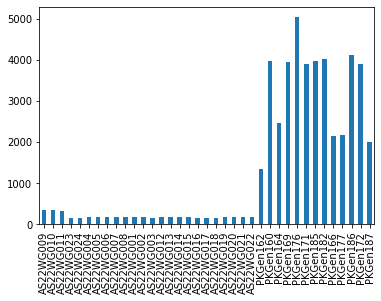

In [18]:
both_v.plot.bar()